#Bandits (student version)

In this lab we will empirically study different startegies for multi-armed bandits. First let us create MBA environment.


In [ ]:
# Create simple bandit environment and import utils
import matplotlib.pyplot as plt
import numpy as np
import random


class BernoulliBandit():
    def __init__(self, p):
        self.p = p

    def act(self):
        return int(random.random() < self.p)

    def expected_value(self):
        return self.p


class MultiArmBandit():
    def __init__(self, one_arm_bandits_list):
        self.list_of_bandits = one_arm_bandits_list
        self.expected_returns = [bandit.expected_value() for bandit in self.list_of_bandits]
        self.oracle = np.argmax(self.expected_returns)
        self.max_expected_return = max(self.expected_returns)
        self.rewards_sum  = 0
        self.t = 0
        self.n_bandits = len(self.list_of_bandits)

    def act(self, a):
        self.t += 1
        reward = self.list_of_bandits[a].act()
        self.rewards_sum += reward
        return reward

    def regret(self):
        return self.t*self.max_expected_return - self.rewards_sum

    def reset(self):
        self.t = 0
        self.rewards_sum = 0

Lets create a MBA with several Bernoulli bandits with random parameters:

In [ ]:
#Create sample MBA
mba = MultiArmBandit([BernoulliBandit(random.random()) for _ in range(6)])

Let us test this this environment by choosing random actions:

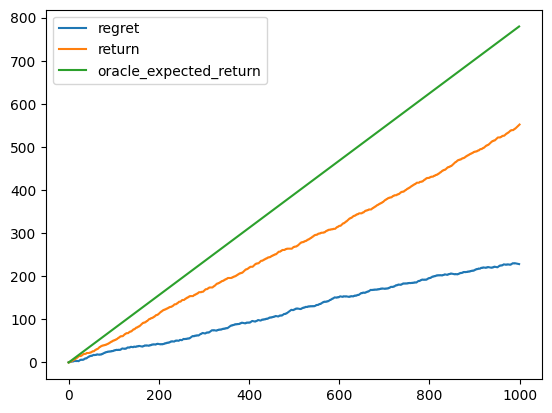

In [ ]:
rewards = [0]
regrets = []
mba.reset()
for _ in range(1000):
  action = random.randint(0, mba.n_bandits - 1)
  reward = mba.act(action)
  rewards.append(reward + rewards[-1])
  regrets.append(mba.regret())

oracle_expected_reward = [mba.max_expected_return*i for i in range(1000)]
plt.plot(regrets, label='regret')
plt.plot(rewards, label='return')
plt.plot(oracle_expected_reward, label='oracle_expected_return')
plt.legend(loc="upper left")
plt.show()

#Common sense strategies
In this section we we will take a closer look at regret as a function of time for several naive bandit algorithms.

In [ ]:
# code for testing a bandit algorithm
def test_bandit_alg(multi_armed_bandit, algorithm, T):
    multi_armed_bandit.reset()
    algorithm.reset()
    regret_history = []
    last_reward = None
    last_action = None

    for num in range(T):
        action = algorithm.act(last_reward, last_action)
        last_action = action
        last_reward = multi_armed_bandit.act(action)
        regret_history.append(multi_armed_bandit.regret())
    return regret_history

def test_bandit_n_times(multi_armed_bandit, algorithm, T, n_trials, plot=False):
    regrets = []
    for t in range(n_trials):
        regrets.append(test_bandit_alg(multi_armed_bandit, algorithm, T))
    avg_regret= np.mean(regrets, axis=0)
    final_regrets = [regrets[i][-1] for i in range(n_trials)]
    return avg_regret, final_regrets

def test_many_algs_plot(multi_armed_bandit, algs_list, T, n_trials):
    plt.clf()
    for alg in algs_list:
        avg_regret, _ = test_bandit_n_times(multi_armed_bandit, alg, T, n_trials)
        plt.plot(avg_regret, label=alg.name)
    plt.legend(loc="upper left")
    plt.show()

##Frequentist approach:
First let us implement a general class for frequentist methods, i.e. algorithms that use history/experience to estimate the expected value of every bandit.

**Exercise: fill the gaps in the following code of general FrequentistBanditAlgorithm**

In [ ]:
class FrequentistBanditAlgorithm:
    def __init__(self, n_bandits, name):
        self.n_bandits = n_bandits # algorithm name
        self.name = name # algorithm name
        self.reset()

    def update_history(self, last_reward, last_action):
        if last_reward is not None:
            self.empirical_rewards[last_action] += last_reward
        if last_action is not None:
            self.action_stats[last_action] += 1

    def empirical_expected_returns(self):
        def evaluate_bandit(action):
            # The function return estimate of the expected value of bandit
            # Hint: divide the empirical_rewards accumulated by choosing action
            # by the number of times the action was chosen
            # if the action was never tested return float('inf')
            if self.action_stats[action] == 0:
                return float('inf')
            return self.empirical_rewards[action]/self.action_stats[action]
        return [evaluate_bandit(a) for a in range(self.n_bandits)]

    def reset(self):
        self.empirical_rewards = {a: 0 for a in range(self.n_bandits)}
        self.action_stats = {a: 0 for a in range(self.n_bandits)}
        self.t = 0

### Follow the leader (full exploitation)
The first algorithm we will consider is the one that always chooses the action with highest estimated reward.
**Exercise: fill the gaps in the code below**

In [ ]:
class FollowTheLeader(FrequentistBanditAlgorithm):
    def __init__(self, n_bandits):
        super().__init__(n_bandits, 'FTL')

    def act(self, last_reward, last_action):
        self.update_history(last_reward, last_action)
        return np.argmax(self.empirical_expected_returns()) #choose the best action

Lets see FTA statistics: regret histogram and averaged regret as a function of time.

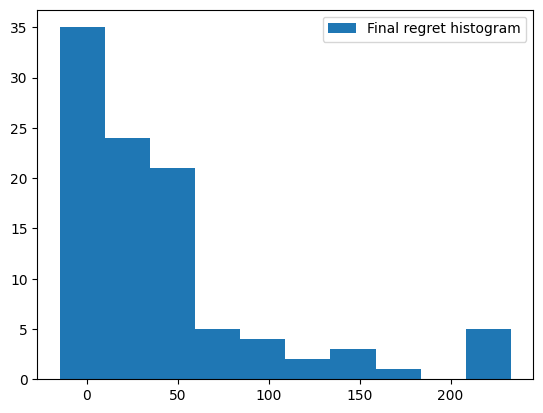

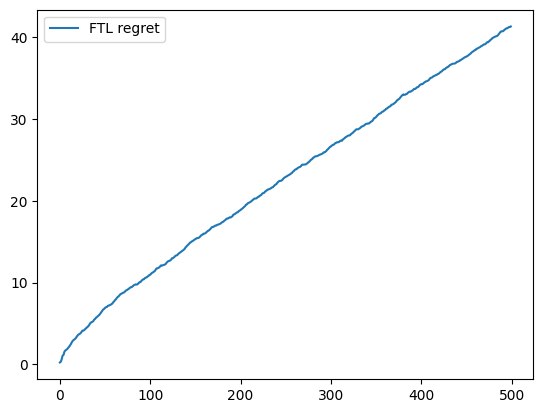

In [ ]:
regret_avg, final_regret = test_bandit_n_times(mba, FollowTheLeader(mba.n_bandits), 500, 100)
plt.hist(final_regret, label='Final regret histogram')
plt.legend(loc="upper right")
plt.show()
plt.clf()
plt.plot(regret_avg, label='FTL regret')
plt.legend(loc="upper left")
plt.show()

**Question: what is the primary cause of linear regret for FTL agent?**
The primary cause of linear regret for the Follow-The-Leader (FTL) agent is its tendency to overexploit the action that has performed best in the past, without sufficient exploration of other actions

### Epsilon-greedy (naive exploration)
The next naive algorithm is FTL with a modification: we will test random actions with the probability epsilon.

**Exercise: fill the gaps in the code below**

In [ ]:
class EpsilonGreedy(FrequentistBanditAlgorithm):
    def __init__(self, n_bandits, epsilon):
        super().__init__(n_bandits, f'epsilon {epsilon}')
        self.epsilon = epsilon

    def act(self, last_reward, last_action):
        self.update_history(last_reward, last_action)
        actions = self.empirical_expected_returns()
        # With probability epsilon choose random action,
        # with probability 1 - epsilon choose action with highest estimated value
        if random.uniform(0, 1) < self.epsilon:
          return random.randint(0, len(actions)-1)
        return np.argmax(actions)

We will now analyze how different values of epsilon affect regret curves

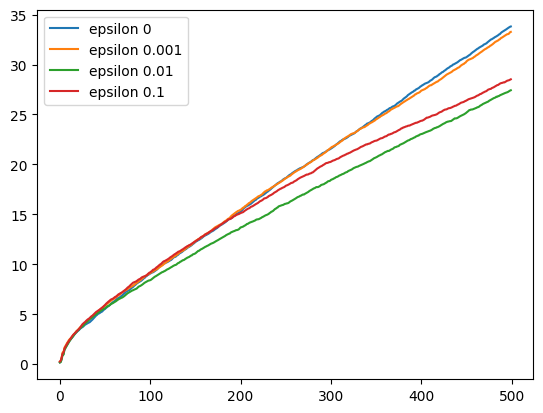

In [ ]:
test_many_algs_plot(mba, [EpsilonGreedy(mba.n_bandits, epsilon) for epsilon in [0, 0.001, 0.01, 0.1]], 500, 500)

As long as epsilon is constant with a have a fixed probability of choosiing non-optimal action at every step. Hence, we cannot expect sub-lineat regret.

**Exercise: implement a version of epsilon greedy agent with epsilon annealing, i.e. epsilon converging to 0.**

In [ ]:
class EpsilonGreedyAnnealing(FrequentistBanditAlgorithm):
    def __init__(self, n_bandits, epsilon, epsilon_decay_rate):
        super().__init__(n_bandits, f'epsilon {epsilon} decay {epsilon_decay_rate}')
        self.initial_epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.epsilon = epsilon

    def agent_specific_reset(self):
      # this function will reset the epsilon every time we start the experiment
      self.epsilon = self.initial_epsilon

    def act(self, last_reward, last_action):
      self.update_history(last_reward, last_action)
      self.epsilon *= self.epsilon_decay_rate
      actions = self.empirical_expected_returns()
      if random.uniform(0, 1) < self.epsilon:
        return random.randint(0, len(actions)-1)
      return np.argmax(actions)
      # Update epsilon, choose random action with p=epsilon,
      # estimated best action with p = 1 - epsilon

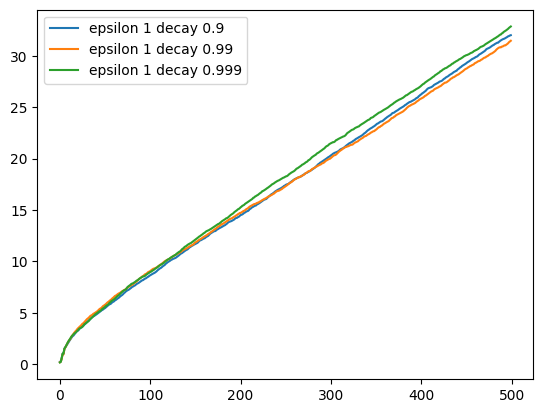

In [ ]:
test_many_algs_plot(mba, [EpsilonGreedyAnnealing(mba.n_bandits, 1, decay) for decay in [0.9, 0.99, 0.999]], 500, 500)

### UCB1 score (adaptive exploration)
EpsilonGreedy does not have any preference for which actions to explore. It would be much better to have eploration based on the uncertainity of a given action.

**Exercise: fill the gaps in the code of UCB1 algorithm.**

In [ ]:
class UCB1(FrequentistBanditAlgorithm):
    def __init__(self, n_bandits, alpha):
        super().__init__(n_bandits, f'UCB alpha = {alpha}')
        self.alpha = alpha

    def scores(self):
        exploitation_terms = self.empirical_expected_returns()
        t = sum([self.action_stats[x] for x in range(self.n_bandits)])

        def exploration_score(action):
            if self.action_stats[action] > 0:
                return self.alpha * np.sqrt((2 * np.log(t)) / self.action_stats[action]) #Formula for exploration term in UCB1
            else:
                return float('inf')

        exploration_terms = [exploration_score(action) for action in range(self.n_bandits)]
        return [expl + explo for expl, explo in zip(exploitation_terms, exploration_terms)] #Add exploration and exploitation terms to get scores of each action

    def act(self, last_reward, last_action):
        self.update_history(last_reward, last_action)
        return np.argmax(self.scores())

Lets check if UCB1 can do better than linear:

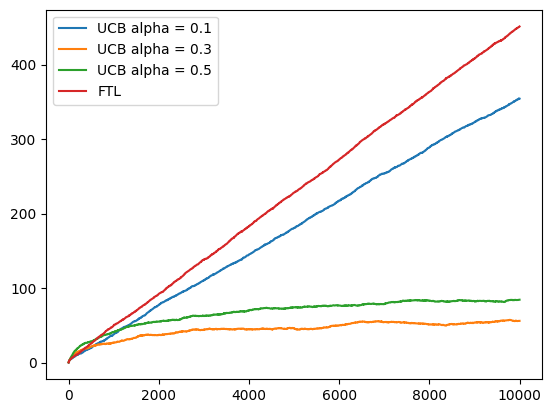

In [ ]:
test_many_algs_plot(mba, [UCB1(mba.n_bandits, alpha) for alpha in [0.1, 0.3, 0.5]] + [FollowTheLeader(mba.n_bandits)], 10000, 50)

##Beyesian approach: Thompson sampling
UCB1 does not take into account the distribution of rewards. Lets see if can do better, by including it.
**Exercise: fill the gaps in the code below**

In [ ]:
class ThompsonSampling():
    name = 'Thompson'
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        self.reset()

    def act(self, last_reward, last_action):
        if last_reward is not None:
            self.alpha_beta_list[last_action][0] += last_reward
            self.alpha_beta_list[last_action][1] += 1 - last_reward

        thetas = [] #We wan to sample parameters for bandits from beta distribution
        for action in range(self.n_bandits):
            thetas.append(np.random.beta(self.alpha_beta_list[action][0], self.alpha_beta_list[action][1]))
        return np.argmax(thetas)

    def reset(self):
        self.alpha_beta_list = [[0.5, 0.5] for _ in range(self.n_bandits)]

Let us compare Thompson sampling against UCB1 score algorithm:

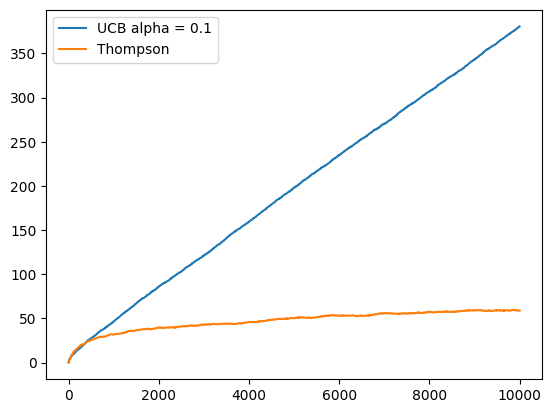

In [ ]:
test_many_algs_plot(mba, [UCB1(mba.n_bandits, alpha) for alpha in [0.1]] + [ThompsonSampling(mba.n_bandits)], 10000, 100)